# Experiment

Richard Wen  
rwen@ryerson.ca  

This notebook details an experiment on stop sign detection using [Google Street View images](https://developers.google.com/maps/documentation/streetview/). The object detection model is based on the [Haar Cascade Classifier](http://docs.opencv.org/3.2.0/dc/d88/tutorial_traincascade.html) by [Viola and Jones (2001)](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) available in the [Open Source Computer Vision (OpenCV)](http://opencv.org/) software.

## 1.0 Requirements

* [Anaconda Python 3](https://www.continuum.io/downloads)
* [OpenCV3](http://opencv.org/)
* [google_streetview](https://pypi.python.org/pypi/google-streetview/)
* [matplotlib](https://matplotlib.org/)
* [numpy](http://www.numpy.org/)
* [requests](https://pypi.python.org/pypi/requests)

### 1.1 Setup

Import the following modules:

In [2]:
%matplotlib inline

from glob import glob
from os import makedirs, path

import cv2
import google_streetview.api
import json
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import requests
import shutil
import sys
import warnings

### 1.2 Folders

The following folders are required:

In [110]:
folders = [
    '_img',
    'data',
    'positives',
    'negatives'
]
for folder_path in folders:
    if not path.isdir(folder_path):
        makedirs(folder_path)

### 1.3 Functions

The following functions are needed

In [3]:
def classify(model_path, images):
    """Download data from a url.

    Downloads the data from a Uniform Resource Locator (URL) link with requests and saves it into a file with shutil.

    Args:
        model_path (str):
            Path of the Haar Cascade xml file.
        images (list):
            List of image file paths to use for classification.
    Returns:
        A ``dict`` of the image path and rectangular region of detected objects.
    """
    model = cv2.CascadeClassifier(model_path)
    detected = []
    for image_path in images:
        image = cv2.imread(image_path)
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rectangles = model.detectMultiScale(grayscale)
        if len(rectangles) > 0:
            detected.append({
                'image_path': image_path,
                'rectangle': rectangles[0]
            })
    return detected

def download(url, file_path):
    """Download data from a url.

    Downloads the data from a Uniform Resource Locator (URL) link with requests and saves it into a file with shutil.

    Args:
        url (str):
            Path of directory to save downloads of images from :class:`api.results`.links
        file_path (str):
            Name of the file with extension to save the :class:`api.results`.metadata
    """
    r = requests.get(url, stream=True)
    if r.status_code == 200: # if request is successful
        with open(file_path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    else: # show warning if request fails
        warnings.warn('Download failed for: ' + url)

def plot_detected(detected, save_path=None, save_dpi=300):
    """Plot and save detected objects.
    Args:
        haars (listof numpy.array):
            List of ``dict`` with image_path and rectangle keys.
        save_path (str):
            Path to save the examples.
        save_dpi (int):
            Resolution quality of the output file.
    """
    
    # Base plot
    n = len(detected)
    f, ax = plt.subplots(1, n)
    ax = ax if n > 1 else [ax]
    
    # Plot detections
    for i in range(n):
        
        # Obtain values
        image_path = detected[i]['image_path']
        x, y, w, h = detected[i]['rectangle']
        
        # Draw image and crop
        image = cv2.imread(image_path)
        image = image[y:y + h, x:x + w]
        ax[i].imshow(image, cmap='gray_r')
        
        # Remove axis
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    
    # Save plot
    if save_path is not None:
        plt.savefig(save_path, dpi=save_dpi)

## 2.0 Performance Evaluation

A set of positive and negative images were required to evaluate a Haar Cascade Classifier for stop signs. Positive images are example images that contain the object to be detected, and negative images are example images that do not contain the object to be detected. The positive and negative images were extracted by locating stop signs from [OpenStreetMap](https://www.openstreetmap.org), and querying Google Street View using those locations. The data was then manually inspected to be labelled as positive or negative, and was used for performance evaluation.

### 2.1 Data

A [google_streetview](https://pypi.python.org/pypi/google-streetview/) Python package was developed to interact with the [Google Street View Image API](https://developers.google.com/maps/documentation/streetview/) and download Street View imagery.

The `google_streetview` package was installed with a Python command line tool named `pip`:

```
pip install google_streetview
```

#### 2.1.1 Stop Sign Locations

The stop sign locations were extracted for Toronto, Ontario, using the [Overpass API query language]((http://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide). Points in overpass are defined as `node`, and stop signs are tagged as `highway=stop`. A bounding box containing the latitude and longitude coordinates to the bottom left corner (`43.458297, -79.639219`), and top right corner (`43.8554579,-79.002481`) was used to filter points to Toronto. The final query is defined as `node[highway=stop](43.458297,-79.639219,43.8554579,-79.002481)`.

The data was downloaded using a query string in a [Uniform Resource Locator](http://www.rfc-editor.org/rfc/rfc1738.txt) (URL) link into the folder `data/google_streetview`:

In [112]:
# Create overpass query string url
overpass_server = 'http://overpass-api.de/api/interpreter?data='
overpass_query = '[out:json];node[highway=stop](43.458297,-79.639219,43.8554579,-79.002481);out;'
overpass_url = overpass_server + overpass_query

# Download the json of stop sign locations
download(overpass_url, 'data/locations.json')

#### 2.1.2 Google Streetview Images

The Google Street View images were extracted using the [Google Street View Image API](https://developers.google.com/maps/documentation/streetview/).

The Google Street View Image API allowed the user to set the following parameters for free usage provided a [Developer Key](https://developers.google.com/api-client-library/python/guide/aaa_apikeys) (last updated June 26, 2017):

* **location** or **pano** *[Required]*: coordinates (latitude, longitude) or address
* **key** *[Required]*:  the google developer key
* **heading**: compass rotation of camera from 0 to 360 degrees (the default directs it to face the location)
* **fov**: horizontal field of view from 0 to 120 (default is 90)
* **pitch**: vertical angle of camera from -90 to 90 with 0 being in the middle (the default is 0)
* **size**: image size up to 640 by 640

Out of the 10401 stop sign locations extracted from OpenStreetMap using the Overpass API, 99 were randomly selected to be used for object detection. These 99 locations were referred to as the testing data, and were used to extract 99 Google Street View images using the `google_streetview` package. The extracted Street View images were then manually inspected to divide them into positive (image has a stop sign), and negative (image does not have a stop sign) labels.

In [ ]:
# Obtain stop sign locations data
with open('data/locations.json') as json_file:
    
    # Extract locations
    data = json.load(json_file)
    locations = []
    for element in data['elements']:
        longitude = element['lon']
        latitude = element['lat']
        locations.append([latitude, longitude])
    locations = np.array(locations)
    np.savetxt('data/coordinates.txt', locations, fmt='%f')
    
    # Randomly select 99 locations
    random = np.random.RandomState(0)
    random_select = random.randint(locations.shape[0], size=100)
    locations = locations[random_select]
    np.savetxt('data/coordinates_random.txt', locations, fmt='%f')
    

# Define parameters for street view api
dev_key = input('Developer Key: ')
params = []
for l in locations:
    params.append({
        'size': '640x640',
        'location': str(l[0]) + ',' + str(l[1]),
        'fov': '120',
        'key': dev_key
    })

# Create a results object
results = google_streetview.api.results(params)

# Download images
results.download_links('data/streetview')

Manually label 19 Street View images positive to be copied to the `positives` folder for testing:

In [162]:
# Manually label positive images
positives = [
    'data/streetview\\gsv_1.jpg',
    'data/streetview\\gsv_14.jpg',
    'data/streetview\\gsv_18.jpg',
    'data/streetview\\gsv_19.jpg',
    'data/streetview\\gsv_20.jpg',
    'data/streetview\\gsv_30.jpg',
    'data/streetview\\gsv_32.jpg',
    'data/streetview\\gsv_36.jpg',
    'data/streetview\\gsv_38.jpg',
    'data/streetview\\gsv_40.jpg',
    'data/streetview\\gsv_46.jpg',
    'data/streetview\\gsv_48.jpg',
    'data/streetview\\gsv_49.jpg',
    'data/streetview\\gsv_70.jpg',
    'data/streetview\\gsv_71.jpg',
    'data/streetview\\gsv_80.jpg',
    'data/streetview\\gsv_81.jpg',
    'data/streetview\\gsv_86.jpg',
    'data/streetview\\gsv_87.jpg'
]

# Copy images to positives folder
for image_path in positives:
    shutil.copy(image_path, 'positives')

Label the rest of the 80 Street View images that are not positive as negative to be copied to the `negatives` folder for testing:

In [163]:
# Label rest of images negative
negatives = [x for x in glob('data/streetview/*.jpg') 
             if x not in positives]

# Copy images to negatives folder
for image_path in negatives:
    shutil.copy(image_path, 'negatives')

### 2.2 Classification

The 99 Google Street View images that were divided into positive and negative labels were used as testing data.

Using the Haar Cascade model provided by Github user [markgaynor](https://github.com/markgaynor) in `data/cascade.xml`, the positive data and negative data was classified as having a stop sign (positive) or not having a stop sign (negative):

In [4]:
# Testing data
positive_tests = glob('positives/*.jpg')
negative_tests = glob('negatives/*.jpg')

# Classify street view images
positive_detections = classify('data/cascade.xml', positive_tests)
negative_detections = classify('data/cascade.xml', negative_tests)

# Metrics
d_positive = len(positive_detections) # num of detected positive images
n_positive = len(positive_tests) # num of positive images
d_negative = len(negative_detections) # num of detected negative images
n_negative = len(negative_tests) # num of negative images

Positive detections are show below:

Correctly detected 6 out of 19


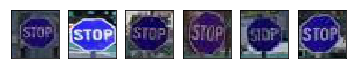

In [165]:
print('Correctly detected ' + str(d_positive) + ' out of ' + str(n_positive))
plot_detected(positive_detections, '_img/positive_detections.pdf')

Negative detections are show below:

Incorrectly detected 1 out of 80


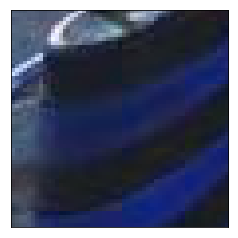

In [6]:
print('Incorrectly detected ' + str(d_negative) + ' out of ' + str(n_negative))
plot_detected(negative_detections, '_img/negative_detections.pdf')

## References

* [Face Detection using Haar Cascades](http://docs.opencv.org/3.2.0/d7/d8b/tutorial_py_face_detection.html)